## Task Description

=> 작가의 글을 분석하여 특징을 도출하는 알고리즘 개발.


In [16]:
!pip install transformers

In [17]:
!pip install tokenization

In [18]:
import pandas as pd
import numpy as np
import re, gc

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

## RNN, LSMTM
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
from transformers import BertTokenizer
import tokenization

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

## 1-1. 데이터 불러오기


In [19]:
# train 데이터 불러오기
train = pd.read_csv("/kaggle/input/vc-writers/train.csv")
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [20]:
# test 데이터 불러오기
test = pd.read_csv("/kaggle/input/vc-writers/test_x.csv")
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


## 1-2. 불용어 제거

In [21]:
# 부호 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# 소문자로 바꾼 후 전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

## 1-3. 데이터 시각화

<Axes: title={'center': 'Samples per each class (Training set)'}, xlabel='author'>

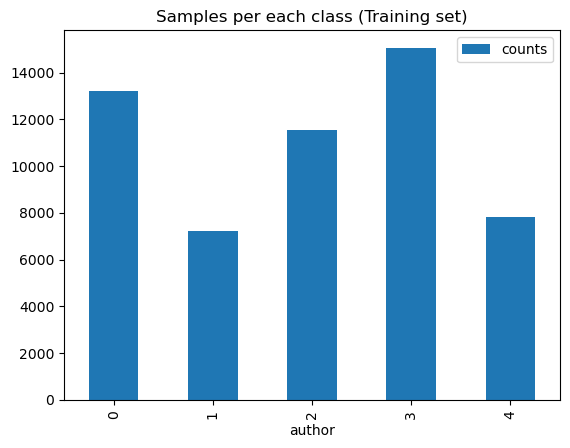

In [22]:
# 작가별 분포도 확인 
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)")

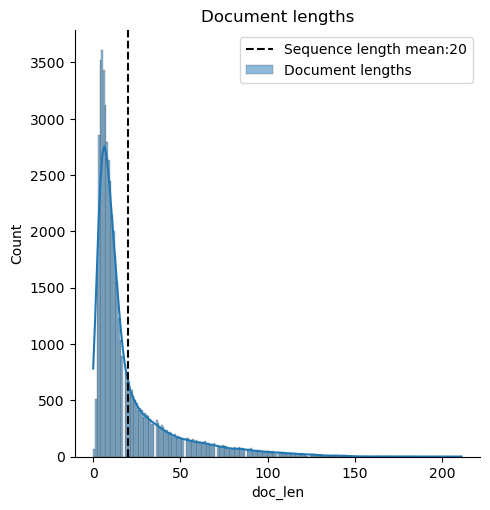

 가장 긴 문장은 211 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [23]:
# 문장 길이 분포도 확인
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.displot(dataframe.doc_len, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

## 2.1 Tokenization

In [24]:
max_length = 150
n_class = 5

In [25]:
def bert_encode(texts, tokenizer, max_len=max_length):
    all_tokens = []  # 모든 토큰을 담을 리스트
    all_masks = []  # 어텐션 마스크를 담을 리스트
    all_segments = []  # 세그먼트 ID를 담을 리스트

    for text in texts:
        text = tokenizer.tokenize(text)  # 텍스트를 토큰화
            
        text = text[:max_len-2]  # 최대 길이에서 2를 뺀 길이까지만 남김
        input_sequence = ["[CLS]"] + text + ["[SEP]"]  # 시작 토큰과 종료 토큰을 추가한 입력 시퀀스
        pad_len = max_len - len(input_sequence)  # 패딩할 길이 계산
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)  # 토큰을 토큰 ID로 변환
        tokens += [0] * pad_len  # 패딩 길이만큼 0으로 채움
        pad_masks = [1] * len(input_sequence) + [0] * pad_len  # 입력 토큰은 1로 마스크, 패딩은 0으로 마스크
        segment_ids = [0] * max_len  # 세그먼트 ID는 모두 0
        
        all_tokens.append(tokens)  # 토큰 리스트에 추가
        all_masks.append(pad_masks)  # 어텐션 마스크 리스트에 추가
        all_segments.append(segment_ids)  # 세그먼트 ID 리스트에 추가
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


In [26]:
# 사전 훈련된 BERT 모델의 토크나이저를 불러옵니다
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 토큰화
X_train = bert_encode(train.text.values, tokenizer, max_len=max_length)
X_test = bert_encode(test.text.values, tokenizer, max_len=max_length)
Y_train = train['author'].values

print(X_train[0].shape)
print(X_test[0].shape)
print(Y_train.shape)

(54879, 150)
(19617, 150)
(54879,)


In [27]:
# 토큰 배열의 값 확인
print(X_train[0])
print(X_test[0])
print(Y_train)

[[  101  2471 18329 ...     0     0     0]
 [  101  2905  2356 ...     0     0     0]
 [  101  5117  2028 ...     0     0     0]
 ...
 [  101 18006  2092 ...     0     0     0]
 [  101  2359 18496 ...     0     0     0]
 [  101  5121  2025 ...     0     0     0]]
[[  101  2025  2228 ...     0     0     0]
 [  101  2053  3880 ...     0     0     0]
 [  101  3203  3090 ...     0     0     0]
 ...
 [  101 26195  3344 ...     0     0     0]
 [  101  2574  2588 ...     0     0     0]
 [  101  4788 20076 ...     0     0     0]]
[3 2 1 ... 1 3 0]


## 3.Bert


In [28]:
class Bert(tf.keras.Model):
    def __init__(self, bert_layer, max_len=max_length, n_class=n_class):
        super(Bert, self).__init__()

        self.bert_layer = bert_layer  # BERT 레이어 객체를 저장하는 변수
        self.max_len = max_len  # 최대 길이를 저장하는 변수
        self.n_class = n_class  # 클래스 개수를 저장하는 변수

    def call(self, inputs):
        return self.output_layer

    def get_model(self):
        # BERT 모델의 입력을 정의하는 데 사용되는 입력 레이어들을 생성
        input_word_ids = tf.keras.Input(shape=(self.max_len,), dtype=tf.int32, name="input_word_ids")
        input_attention_mask = tf.keras.Input(shape=(self.max_len,), dtype=tf.int32, name="input_attention_mask")
        segment_ids = tf.keras.Input(shape=(self.max_len,), dtype=tf.int32, name="segment_ids")

        _, sequence_output = self.bert_layer([input_word_ids, input_attention_mask, segment_ids])  # BERT 레이어를 통과한 결과
        clf_output = sequence_output[:, 0, :]  # [CLS] 토큰의 출력을 사용하여 분류 작업에 필요한 특성 벡터 추출
        x = tf.keras.layers.Dense(256, activation='relu')(clf_output)  # 256개의 뉴런을 가진 은닉층을 추가
        out = tf.keras.layers.Dense(self.n_class, activation='softmax')(x)  # 클래스 개수에 맞는 출력층을 추가

        model = tf.keras.models.Model(inputs=[input_word_ids, input_attention_mask, segment_ids], outputs=out)  # 입력과 출력을 사용하여 모델 객체 생성
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])  # 모델 컴파일

        return model


In [30]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [31]:
bert = Bert(bert_layer, max_len=max_length, n_class=n_class)
model = bert.get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_attention_mask (InputLay  [(None, 150)]       0           []                               
 er)                                                                                              
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',     

In [34]:
n_fold = 3  # 교차 검증 폴드 수
seed = 42  # 재현성을 위한 시드 값

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)  # Stratified K-Fold 교차 검증 객체 생성

p_val = np.zeros((X_train[0].shape[0], n_class))  # 검증 데이터 예측 결과를 저장할 배열 초기화
p_tst = np.zeros((X_test[0].shape[0], n_class))  # 테스트 데이터 예측 결과를 저장할 배열 초기화

history = []  # 각 교차 검증 폴드의 학습 이력을 저장할 리스트 초기화

for i, (i_trn, i_val) in enumerate(cv.split(X_train[0], Y_train), 1):
    print(f'training model for CV #{i}')
    
    es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)  # 매 폴드마다 새로운 EarlyStopping 객체 생성
    
    model = bert.get_model()  # BERT 모델 생성
    
    temp = model.fit([x[i_trn] for x in X_train],
                     to_categorical(Y_train[i_trn]),
                     validation_data=([x[i_val] for x in X_train], to_categorical(Y_train[i_val])),
                     epochs=10,
                     batch_size=8,
                     callbacks=[es])  # BERT 모델 학습
    
    history.append(temp)  # 학습 이력 저장
    p_val[i_val, :] = model.predict([x[i_val] for x in X_train])  # 검증 데이터 예측 결과 저장
    p_tst += model.predict(X_test) / n_fold  # 테스트 데이터 예측 결과 누적
    
    del model  # 사용한 모델 삭제
    clear_session()  # 메모리 정리
    gc.collect()  # 가비지 컬렉션 실행


training model for CV #1
Epoch 1/10
4574/4574 [==============================] - 2632s 558ms/step - loss: 0.9227 - accuracy: 0.6345 - val_loss: 0.7817 - val_accuracy: 0.6966
Epoch 2/10
4574/4574 [==============================] - 2546s 557ms/step - loss: 0.4646 - accuracy: 0.8312 - val_loss: 0.7386 - val_accuracy: 0.7404
Epoch 3/10
4574/4574 [==============================] - 2545s 556ms/step - loss: 0.1517 - accuracy: 0.9471 - val_loss: 0.9063 - val_accuracy: 0.7408
Epoch 4/10
4574/4574 [==============================] - 2546s 557ms/step - loss: 0.0774 - accuracy: 0.9741 - val_loss: 1.1724 - val_accuracy: 0.7357
Epoch 4: early stopping
614/614 [==============================] - 353s 575ms/step
training model for CV #2
Epoch 1/10
4574/4574 [==============================] - 2622s 557ms/step - loss: 0.6141 - accuracy: 0.7734 - val_loss: 0.4600 - val_accuracy: 0.8321
Epoch 2/10
4574/4574 [==============================] - 2544s 556ms/step - loss: 0.2351 - accuracy: 0.9182 - val_loss: 0.4

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[8,16,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node encoder/layer_21/self_attention/einsum/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_567312]

[<keras.callbacks.History object at 0x7dd06ab788b0>, <keras.callbacks.History object at 0x7dd06bd7b700>]


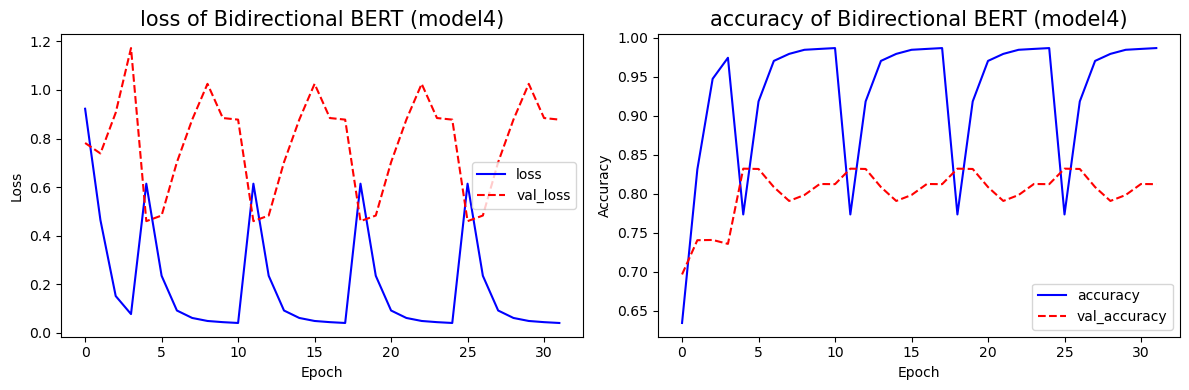

In [46]:
# 학습 내역 결합
combined_history = {}
print(history)
for i, hist in enumerate(history):
    for key, value in hist.history.items():
        if key in combined_history:
            combined_history[key].extend(value)
        else:
            combined_history[key] = value
            
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))
          
plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional BERT (model4)', fontsize=15)
plt.plot(combined_history['loss'], 'b-', label='loss')
plt.plot(combined_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional BERT (model4)', fontsize=15)
plt.plot(combined_history['accuracy'], 'b-', label='accuracy')
plt.plot(combined_history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# sample_submission 에 대입
transformer_submission = pd.read_csv("/kaggle/input/vc-writers/sample_submission.csv")
transformer_submission[['0','1','2','3','4']] = p_tst

# CSV 파일로 저장
transformer_submission.to_csv('transformer_submission_predictions.csv', index=False)
transformer_submission

,index,0,1,2,3,4
0,0,0.004161,0.024896,0.634421,0.001243,0.001945
1,1,0.102195,0.521950,0.001958,0.006815,0.033749
2,2,0.665501,0.000111,0.000685,0.000077,0.000292
3,3,0.005574,0.006887,0.651609,0.000298,0.002299
4,4,0.580775,0.003975,0.009858,0.014808,0.057251
...,...,...,...,...,...,...
19612,19612,0.008976,0.654943,0.001056,0.001495,0.000196
19613,19613,0.000159,0.000778,0.005698,0.000143,0.659889
19614,19614,0.009011,0.656041,0.001326,0.000147,0.000141
19615,19615,0.011001,0.646617,0.008540,0.000402,0.000108


## SCORE